# Packages:

In [ ]:
try:
  from google.colab import drive
  !nvidia-smi
  drive.mount('/content/drive')
  path = 'drive/MyDrive/Thesis WU/'
except:
  path = './'

Tue Jul 11 13:23:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install keras_preprocessing
!pip install transformers
from nltk import download
download('punkt')
!pip install lime

In [ ]:
# Packages for loading data:
from os import walk
import re
import pickle
import sys

# Packages for effective data storage / math utils:
import pandas as pd
import numpy as np

# Packages for plotting:
import seaborn as sns
import matplotlib.pyplot as plt

# Packages for test train data prep:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

# Packages for text representation:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation

# Packages for classical modeling:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Packages for deep learning:
import keras
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import (Embedding, Dense, Flatten, Input, Lambda,
                          GlobalMaxPooling1D, MaxPooling1D, Conv1D,
                          Bidirectional, GRU, LSTM,
                          TimeDistributed, Dropout)
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from transformers import BertTokenizer, TFBertForSequenceClassification
from keras.utils import to_categorical
from nltk.tokenize import sent_tokenize

# Packages for performance:
from sklearn.metrics import accuracy_score, f1_score

# Packages for model interpretation:
from lime import lime_text

# Misc.:
import time
import multiprocessing

seed = 101
cores = multiprocessing.cpu_count()

# Classical Models Training:


**Function:**

1. Read in input data/model to use.

2. Runs hyperparameter tuning via 5-fold CV on training set with given model and data. Saves optimal hyperparameters and saves best model in a pickle.

---------------

**Classical Models:**

* Logistic Regression
* Gaus. Naïve Bayes
* SVM
* DT
* RF
* LightGBM
* k-NN
* perceptron (single & multi)

---------------

**Input Data:**

* Bag-of-ngarms: ngram (1, 1) (+ Truncated SVD) (+ LDA)
* Bag-of-ngarms: ngram (1, 2) (+ Truncated SVD) (+ LDA)
* TF-IDF: ngram (1, 1) (+ Truncated SVD) (+ LDA)
* TF-IDF: ngram (1, 2) (+ Truncated SVD) (+ LDA)
* Word2Vec
* Doc2Vec
* GloVe

In [ ]:
def vec_path_getter(
    vecpath : str,
    contains : str,
):
    #########
    # Input:
    # Output: list of all paths to jasons to be used later
    #########

    filenames = next(walk(vecpath), (None, None, []))[2]
    filenames = [str(vecpath + "/" + file) for file in filenames
                 if contains in file]

    return(filenames)

vec_x_paths = vec_path_getter(
    path + "ECHR_Dataset_vec",
    "x"
    )
pattern = r'(?<=vec/)(.*?)(?=_test_x.parquet.gzip|_train_x.parquet.gzip)'
unique_datasets = list(set([re.search(pattern, string).group(0) for string in vec_x_paths]))
vec_x_paths = [[x for x in vec_x_paths if str(i + "_train") in x or str(i + "_test") in x] for i in unique_datasets]

y_paths = vec_path_getter(
    path + "ECHR_Dataset_clean",
    "y"
    )

classical_models = [
    LogisticRegression,
    GaussianNB,
    SVC,
    DecisionTreeClassifier,
    RandomForestClassifier,
    LGBMClassifier,
    KNeighborsClassifier,
    Perceptron,
    MLPClassifier,
    ]
params = [
    { # LogisticRegression
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': [None, 'l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    },
    { # GaussianNB
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    },
    { # SVC
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    },
    { # DecisionTreeClassifier
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(10, 50, 2),
    'splitter': ['best', 'random'],
    'ccp_alpha': np.arange(0, 0.2, 0.01),
    },
    { # RandomForestClassifier
    'n_estimators': np.arange(10, 200, 10),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(10, 50, 2),
    'ccp_alpha': np.arange(0, 0.2, 0.01),
    },
    { # LGBMClassifier
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': [10, 50, 100, 200],
    'max_depth': [5, 10, 15, 20, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    },
    { # KNeighborsClassifier
    'n_neighbors': np.arange(10, 50, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2, 3]
    },
    { # Perceptron
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'max_iter': np.arange(1000, 5000, 1000),
    },
    { # MLPClassifier
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    }
    ]

In [ ]:
def hyperparameter_tuning(model, params, x_train, y_train):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    clf = RandomizedSearchCV(model(), params, cv=kfold, n_iter=100, n_jobs=None, random_state=42)
    search = clf.fit(x_train, y_train)
    best_params = search.best_params_
    best_model = search.best_estimator_

    return best_params, best_model

def save_model(best_model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(best_model, f)

def run_models_on_datasets(models, params, datasets_paths):
    y_train = pd.read_pickle([i for i in y_paths if 'train' in i][0])
    y_test =  pd.read_pickle([i for i in y_paths if 'test'  in i][0])
    pattern = r'(?<=vec/)(.*?)(?=_test_x.parquet.gzip|_train_x.parquet.gzip)'

    for i, model in enumerate(models):
        for j, datasets in enumerate(datasets_paths):
            # Set up:
            datasets.sort()
            temp_model_name = str(model).split('.')[-1].split("'")[0]
            temp_data_name = re.search(pattern, datasets[0]).group(0)
            print(f"Running model {temp_model_name} on dataset {temp_data_name}")

            # Read correct data:
            x_train = pd.read_parquet(datasets[1])

            # Hypertune:
            best_params, best_model = hyperparameter_tuning(model, params[i], x_train, y_train)

            # Save best model:
            filename = f"model_{temp_model_name}__dataset_{temp_data_name}"
            save_model(best_model, path + 'ECHR_model/' + filename + '.pkl')

            # Done:
            print(f"Best Parameters for model {i+1} on dataset {j+1}: ", best_params)

In [ ]:
run_models_on_datasets(classical_models, params, vec_x_paths)

# Running DL models:

**Deep Learning Models:**

* CNN
* GRU
* HAN
* BERT
* LSTM

In [ ]:
df_train_x_raw = pd.read_pickle(path + "ECHR_Dataset_clean/df_train_x.pkl")
df_train_y_raw = pd.read_pickle(path + "ECHR_Dataset_clean/df_train_y.pkl")

# Create validation split:
df_train_all = pd.concat({"TEXT": df_train_x_raw, "new_CONCLUSION": df_train_y_raw}, axis = 1)
df_train, df_val = train_test_split(df_train_all, test_size=0.2, random_state=seed)
df_train_x = df_train.TEXT
df_train_y = df_train.new_CONCLUSION
df_val_x = df_val.TEXT
df_val_y = df_val.new_CONCLUSION

df_test_x  = pd.read_pickle(path + "ECHR_Dataset_clean/df_test_x.pkl")
df_test_y  = pd.read_pickle(path + "ECHR_Dataset_clean/df_test_y.pkl")

df_all_x = pd.concat([df_train_x_raw, df_test_x])
df_all_y = pd.concat([df_train_y_raw, df_test_y])

In [ ]:
def preprocess(mode, vocab_size = 20000, embedding_dim = 256):
    # Preprocessing text data
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(df_train_x)
    sequences_train = tokenizer.texts_to_sequences(df_train_x)
    sequences_val = tokenizer.texts_to_sequences(df_val_x)
    sequences_test = tokenizer.texts_to_sequences(df_test_x)

    max_len = max(
        max([len(i) for i in sequences_train]),
        max([len(i) for i in sequences_val]),
        max([len(i) for i in sequences_test]),
        ) # Max length of each document
    token_train_x = pad_sequences(sequences_train, maxlen=max_len)
    token_val_x = pad_sequences(sequences_val, maxlen=max_len)
    token_test_x = pad_sequences(sequences_test, maxlen=max_len)

    return token_train_x, token_val_x, token_test_x, tokenizer

In [ ]:
token_train_x_bow,   token_val_x_bow,   token_test_x_bow,   tok_bow   = preprocess("count")
token_train_x_tfidf, token_val_x_tfidf, token_test_x_tfidf, tok_tfidf = preprocess("tfidf")
max_len = len(token_train_x_tfidf[0])

In [ ]:
drop_param = 0.2
r_l2_param = l2(0.001)
embed_l2_param = l2(0.0001)

## CNN:

In [ ]:
def model_CNN_build(kernel_regularizer, vocab_size = 20000, embedding_dim = 256, max_len = max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Conv1D(256, 2, activation='relu',
                     kernel_regularizer = kernel_regularizer))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 2, activation='relu',
                     kernel_regularizer = kernel_regularizer))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 2, activation='relu',
                     kernel_regularizer = kernel_regularizer))
    model.add(MaxPooling1D(4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [ ]:
model_CNN_bow       = model_CNN_build(l2(0))
model_CNN_tfidf     = model_CNN_build(l2(0))
model_CNN_bow_reg   = model_CNN_build(r_l2_param)
model_CNN_tfidf_reg = model_CNN_build(r_l2_param)

In [ ]:
model_CNN_build(l2(0)).summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 28659, 256)        5120000   
                                                                 
 conv1d_12 (Conv1D)          (None, 28658, 256)        131328    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 14329, 256)       0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 14328, 128)        65664     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 7164, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 7163, 128)        

In [ ]:
print("CNN Bag-of-Words")
model_CNN_bow.fit(
    token_train_x_bow, df_train_y,
    validation_data=(token_val_x_bow, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_CNN_bow.predict(token_test_x_bow) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

CNN Bag-of-Words
Epoch 1/10
200/200 [==============================] - 70s 276ms/step - loss: 0.6591 - acc: 0.5955 - val_loss: 0.5253 - val_acc: 0.7655
Epoch 2/10
200/200 [==============================] - 47s 235ms/step - loss: 0.3489 - acc: 0.8556 - val_loss: 0.3184 - val_acc: 0.8621
Epoch 3/10
200/200 [==============================] - 46s 228ms/step - loss: 0.1655 - acc: 0.9406 - val_loss: 0.4610 - val_acc: 0.8257
Epoch 4/10
200/200 [==============================] - 43s 214ms/step - loss: 0.0749 - acc: 0.9773 - val_loss: 0.5003 - val_acc: 0.8502
Epoch 5/10
200/200 [==============================] - 38s 190ms/step - loss: 0.0321 - acc: 0.9918 - val_loss: 0.7207 - val_acc: 0.8464
Epoch 6/10
200/200 [==============================] - 34s 171ms/step - loss: 0.0268 - acc: 0.9914 - val_loss: 0.7407 - val_acc: 0.8301
Epoch 7/10
200/200 [==============================] - 32s 159ms/step - loss: 0.0200 - acc: 0.9947 - val_loss: 0.9525 - val_acc: 0.8332
Epoch 8/10
200/200 [==================

In [ ]:
print("CNN TF-IDF")
model_CNN_tfidf.fit(
    token_train_x_tfidf, df_train_y,
    validation_data=(token_val_x_tfidf, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_CNN_tfidf.predict(token_test_x_tfidf) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

CNN TF-IDF
Epoch 1/10
200/200 [==============================] - 48s 227ms/step - loss: 0.6681 - acc: 0.5889 - val_loss: 0.4784 - val_acc: 0.7636
Epoch 2/10
200/200 [==============================] - 42s 210ms/step - loss: 0.3521 - acc: 0.8483 - val_loss: 0.3095 - val_acc: 0.8633
Epoch 3/10
200/200 [==============================] - 39s 196ms/step - loss: 0.1659 - acc: 0.9373 - val_loss: 0.4083 - val_acc: 0.8589
Epoch 4/10
200/200 [==============================] - 35s 175ms/step - loss: 0.0553 - acc: 0.9802 - val_loss: 0.5868 - val_acc: 0.8545
Epoch 5/10
200/200 [==============================] - 34s 169ms/step - loss: 0.0386 - acc: 0.9867 - val_loss: 0.6876 - val_acc: 0.8464
Epoch 6/10
200/200 [==============================] - 33s 167ms/step - loss: 0.0158 - acc: 0.9945 - val_loss: 0.6017 - val_acc: 0.8226
Epoch 7/10
200/200 [==============================] - 32s 157ms/step - loss: 0.0118 - acc: 0.9973 - val_loss: 1.0390 - val_acc: 0.8489
Epoch 8/10
200/200 [========================

In [ ]:
print("CNN Regularized Bag-of-Words")
model_CNN_bow_reg.fit(
    token_train_x_bow, df_train_y,
    validation_data=(token_val_x_bow, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_CNN_bow_reg.predict(token_test_x_bow) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

CNN Regularized Bag-of-Words
Epoch 1/10
200/200 [==============================] - 42s 198ms/step - loss: 0.8850 - acc: 0.5720 - val_loss: 0.6584 - val_acc: 0.7423
Epoch 2/10
200/200 [==============================] - 38s 189ms/step - loss: 0.5139 - acc: 0.8118 - val_loss: 0.5094 - val_acc: 0.7887
Epoch 3/10
200/200 [==============================] - 34s 167ms/step - loss: 0.2914 - acc: 0.9170 - val_loss: 0.4819 - val_acc: 0.8439
Epoch 4/10
200/200 [==============================] - 33s 163ms/step - loss: 0.1529 - acc: 0.9694 - val_loss: 0.5714 - val_acc: 0.8320
Epoch 5/10
200/200 [==============================] - 31s 156ms/step - loss: 0.0964 - acc: 0.9873 - val_loss: 1.0063 - val_acc: 0.7918
Epoch 6/10
200/200 [==============================] - 30s 149ms/step - loss: 0.0635 - acc: 0.9928 - val_loss: 1.0427 - val_acc: 0.7950
Epoch 7/10
200/200 [==============================] - 29s 144ms/step - loss: 0.0617 - acc: 0.9923 - val_loss: 1.0558 - val_acc: 0.8226
Epoch 8/10
200/200 [======

In [ ]:
print("CNN Regularized TF-IDF")
model_CNN_tfidf_reg.fit(
    token_train_x_tfidf, df_train_y,
    validation_data=(token_val_x_tfidf, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_CNN_tfidf_reg.predict(token_test_x_tfidf) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

CNN Regularized TF-IDF
Epoch 1/10
200/200 [==============================] - 42s 198ms/step - loss: 0.8684 - acc: 0.5742 - val_loss: 0.6108 - val_acc: 0.7505
Epoch 2/10
200/200 [==============================] - 38s 188ms/step - loss: 0.4975 - acc: 0.8132 - val_loss: 0.4212 - val_acc: 0.8313
Epoch 3/10
200/200 [==============================] - 35s 174ms/step - loss: 0.2785 - acc: 0.9090 - val_loss: 0.4965 - val_acc: 0.8332
Epoch 4/10
200/200 [==============================] - 32s 162ms/step - loss: 0.1540 - acc: 0.9616 - val_loss: 0.5427 - val_acc: 0.8357
Epoch 5/10
200/200 [==============================] - 29s 145ms/step - loss: 0.0937 - acc: 0.9818 - val_loss: 0.7041 - val_acc: 0.8082
Epoch 6/10
200/200 [==============================] - 29s 145ms/step - loss: 0.0624 - acc: 0.9901 - val_loss: 0.7576 - val_acc: 0.8295
Epoch 7/10
200/200 [==============================] - 27s 135ms/step - loss: 0.0655 - acc: 0.9878 - val_loss: 0.9728 - val_acc: 0.8113
Epoch 8/10
200/200 [============

## GRU:

In [ ]:
def model_GRU_build(kernel_regularizer, vocab_size = 20000, embedding_dim = 256, max_len = max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(GRU(32, activation = 'tanh', recurrent_activation = 'sigmoid',
                  dropout = drop_param,
                  kernel_regularizer = kernel_regularizer))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [ ]:
model_GRU_bow       = model_GRU_build(l2(0))
model_GRU_tfidf     = model_GRU_build(l2(0))
model_GRU_bow_reg   = model_GRU_build(r_l2_param)
model_GRU_tfidf_reg = model_GRU_build(r_l2_param)

In [ ]:
model_GRU_build(l2(0)).summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 28659, 256)        5120000   
                                                                 
 gru_7 (GRU)                 (None, 32)                27840     
                                                                 
 dense_36 (Dense)            (None, 32)                1056      
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 1)                 17        
                                                                 
Total params: 5,149,441
Trainable params: 5,149,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("GRU Bag-of-Words")
model_GRU_bow.fit(
    token_train_x_bow, df_train_y,
    validation_data=(token_val_x_bow, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_GRU_bow.predict(token_test_x_bow) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

GRU Bag-of-Words
Epoch 1/10
200/200 [==============================] - 166s 814ms/step - loss: 0.6632 - acc: 0.5809 - val_loss: 0.6105 - val_acc: 0.6639
Epoch 2/10
200/200 [==============================] - 161s 806ms/step - loss: 0.5085 - acc: 0.7495 - val_loss: 0.6134 - val_acc: 0.6708
Epoch 3/10
200/200 [==============================] - 157s 787ms/step - loss: 0.3232 - acc: 0.8599 - val_loss: 0.7885 - val_acc: 0.6608
Epoch 4/10
200/200 [==============================] - 156s 779ms/step - loss: 0.1920 - acc: 0.9239 - val_loss: 0.9186 - val_acc: 0.6483
Epoch 5/10
200/200 [==============================] - 154s 769ms/step - loss: 0.1194 - acc: 0.9545 - val_loss: 1.1532 - val_acc: 0.6489
Epoch 6/10
200/200 [==============================] - 151s 757ms/step - loss: 0.0878 - acc: 0.9680 - val_loss: 1.3463 - val_acc: 0.6602
Epoch 7/10
200/200 [==============================] - 152s 759ms/step - loss: 0.0569 - acc: 0.9790 - val_loss: 1.7057 - val_acc: 0.6690
Epoch 8/10
200/200 [===========

In [ ]:
print("GRU TF-IDF")
model_GRU_tfidf.fit(
    token_train_x_tfidf, df_train_y,
    validation_data=(token_val_x_tfidf, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_GRU_tfidf.predict(token_test_x_tfidf) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

GRU TF-IDF
Epoch 1/10
200/200 [==============================] - 166s 818ms/step - loss: 0.6602 - acc: 0.5925 - val_loss: 0.5951 - val_acc: 0.6614
Epoch 2/10
200/200 [==============================] - 161s 803ms/step - loss: 0.5107 - acc: 0.7487 - val_loss: 0.6297 - val_acc: 0.6376
Epoch 3/10
200/200 [==============================] - 158s 792ms/step - loss: 0.3429 - acc: 0.8485 - val_loss: 0.7557 - val_acc: 0.6433
Epoch 4/10
200/200 [==============================] - 154s 772ms/step - loss: 0.2177 - acc: 0.9152 - val_loss: 1.0725 - val_acc: 0.6508
Epoch 5/10
200/200 [==============================] - 157s 784ms/step - loss: 0.1395 - acc: 0.9439 - val_loss: 1.1198 - val_acc: 0.6571
Epoch 6/10
200/200 [==============================] - 153s 763ms/step - loss: 0.0913 - acc: 0.9641 - val_loss: 1.4368 - val_acc: 0.6439
Epoch 7/10
200/200 [==============================] - 150s 752ms/step - loss: 0.0725 - acc: 0.9707 - val_loss: 1.4645 - val_acc: 0.6495
Epoch 8/10
200/200 [=================

In [ ]:
print("GRU Regularized Bag-of-Words")
model_GRU_bow_reg.fit(
    token_train_x_bow, df_train_y,
    validation_data=(token_val_x_bow, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_GRU_bow_reg.predict(token_test_x_bow) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

GRU Regularized Bag-of-Words
Epoch 1/10
200/200 [==============================] - 166s 817ms/step - loss: 0.7057 - acc: 0.5728 - val_loss: 0.6279 - val_acc: 0.6370
Epoch 2/10
200/200 [==============================] - 159s 797ms/step - loss: 0.5454 - acc: 0.7301 - val_loss: 0.6276 - val_acc: 0.6483
Epoch 3/10
200/200 [==============================] - 160s 798ms/step - loss: 0.3828 - acc: 0.8397 - val_loss: 0.7390 - val_acc: 0.6527
Epoch 4/10
200/200 [==============================] - 156s 782ms/step - loss: 0.2649 - acc: 0.8963 - val_loss: 0.9031 - val_acc: 0.6439
Epoch 5/10
200/200 [==============================] - 154s 772ms/step - loss: 0.1810 - acc: 0.9365 - val_loss: 1.1261 - val_acc: 0.6583
Epoch 6/10
200/200 [==============================] - 151s 753ms/step - loss: 0.1332 - acc: 0.9550 - val_loss: 1.1557 - val_acc: 0.6502
Epoch 7/10
200/200 [==============================] - 151s 757ms/step - loss: 0.0992 - acc: 0.9693 - val_loss: 1.3250 - val_acc: 0.6489
Epoch 8/10
200/200 

In [ ]:
print("GRU Regularized TF-IDF")
model_GRU_tfidf_reg.fit(
    token_train_x_tfidf, df_train_y,
    validation_data=(token_val_x_tfidf, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_GRU_tfidf_reg.predict(token_test_x_tfidf) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

GRU Regularized TF-IDF
Epoch 1/10
200/200 [==============================] - 166s 816ms/step - loss: 0.7034 - acc: 0.5703 - val_loss: 0.6257 - val_acc: 0.6451
Epoch 2/10
200/200 [==============================] - 159s 794ms/step - loss: 0.5485 - acc: 0.7249 - val_loss: 0.6256 - val_acc: 0.6614
Epoch 3/10
200/200 [==============================] - 158s 791ms/step - loss: 0.3843 - acc: 0.8327 - val_loss: 0.7871 - val_acc: 0.6602
Epoch 4/10
200/200 [==============================] - 156s 782ms/step - loss: 0.2569 - acc: 0.9032 - val_loss: 0.9400 - val_acc: 0.6702
Epoch 5/10
200/200 [==============================] - 154s 769ms/step - loss: 0.1631 - acc: 0.9449 - val_loss: 0.9843 - val_acc: 0.6602
Epoch 6/10
200/200 [==============================] - 152s 759ms/step - loss: 0.1237 - acc: 0.9600 - val_loss: 1.1329 - val_acc: 0.6470
Epoch 7/10
200/200 [==============================] - 151s 757ms/step - loss: 0.0912 - acc: 0.9719 - val_loss: 1.4268 - val_acc: 0.6470
Epoch 8/10
200/200 [=====

## LSTM:

In [ ]:
def model_LSTM_build(kernel_regularizer, dropout, vocab_size = 20000, embedding_dim = 256, max_len = max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(LSTM(128, return_sequences = True,
                   dropout = dropout, kernel_regularizer = kernel_regularizer))
    model.add(LSTM(128,
                   dropout = dropout, kernel_regularizer = kernel_regularizer))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model


In [ ]:
model_LSTM_bow       = model_LSTM_build(l2(0), 0)
model_LSTM_tfidf     = model_LSTM_build(l2(0), 0)
model_LSTM_bow_reg   = model_LSTM_build(r_l2_param, drop_param)
model_LSTM_tfidf_reg = model_LSTM_build(r_l2_param, drop_param)

In [ ]:
model_LSTM_build(l2(0), 0).summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 28659, 256)        5120000   
                                                                 
 lstm_8 (LSTM)               (None, 28659, 128)        197120    
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dense_51 (Dense)            (None, 64)                8256      
                                                                 
 dense_52 (Dense)            (None, 16)                1040      
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 5,458,017
Trainable params: 5,458,017
N

In [ ]:
print("LSTM Bag-of-Words")
model_LSTM_bow.fit(
    token_train_x_bow, df_train_y,
    validation_data=(token_val_x_bow, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_LSTM_bow.predict(token_test_x_bow) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

LSTM Bag-of-Words
Epoch 1/10
200/200 [==============================] - 351s 2s/step - loss: 0.6497 - acc: 0.6010 - val_loss: 0.6058 - val_acc: 0.6708
Epoch 2/10
200/200 [==============================] - 343s 2s/step - loss: 0.4927 - acc: 0.7589 - val_loss: 0.6881 - val_acc: 0.6458
Epoch 3/10
200/200 [==============================] - 341s 2s/step - loss: 0.2967 - acc: 0.8828 - val_loss: 0.7124 - val_acc: 0.6332
Epoch 4/10
200/200 [==============================] - 339s 2s/step - loss: 0.1674 - acc: 0.9396 - val_loss: 1.0384 - val_acc: 0.6508
Epoch 5/10
200/200 [==============================] - 337s 2s/step - loss: 0.1148 - acc: 0.9592 - val_loss: 1.1189 - val_acc: 0.6451
Epoch 6/10
200/200 [==============================] - 335s 2s/step - loss: 0.0891 - acc: 0.9668 - val_loss: 1.3359 - val_acc: 0.6464
Epoch 7/10
200/200 [==============================] - 334s 2s/step - loss: 0.0733 - acc: 0.9718 - val_loss: 1.6326 - val_acc: 0.6420
Epoch 8/10
200/200 [==============================]

In [ ]:
print("LSTM TF-IDF")
model_LSTM_tfidf.fit(
    token_train_x_tfidf, df_train_y,
    validation_data=(token_val_x_tfidf, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_LSTM_tfidf.predict(token_test_x_tfidf) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

LSTM TF-IDF
Epoch 1/10
200/200 [==============================] - 351s 2s/step - loss: 0.6477 - acc: 0.6090 - val_loss: 0.6159 - val_acc: 0.6646
Epoch 2/10
200/200 [==============================] - 345s 2s/step - loss: 0.4952 - acc: 0.7549 - val_loss: 0.6414 - val_acc: 0.6552
Epoch 3/10
200/200 [==============================] - 342s 2s/step - loss: 0.3228 - acc: 0.8648 - val_loss: 0.8268 - val_acc: 0.6665
Epoch 4/10
200/200 [==============================] - 339s 2s/step - loss: 0.1923 - acc: 0.9263 - val_loss: 1.0236 - val_acc: 0.6395
Epoch 5/10
200/200 [==============================] - 336s 2s/step - loss: 0.1190 - acc: 0.9580 - val_loss: 1.1937 - val_acc: 0.6445
Epoch 6/10
200/200 [==============================] - 335s 2s/step - loss: 0.0882 - acc: 0.9672 - val_loss: 1.3296 - val_acc: 0.6539
Epoch 7/10
200/200 [==============================] - 335s 2s/step - loss: 0.0595 - acc: 0.9774 - val_loss: 1.5570 - val_acc: 0.6502
Epoch 8/10
200/200 [==============================] - 334

In [ ]:
print("LSTM Regularized Bag-of-Words")
model_LSTM_bow_reg.fit(
    token_train_x_bow, df_train_y,
    validation_data=(token_val_x_bow, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_LSTM_bow_reg.predict(token_test_x_bow) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

LSTM Regularized Bag-of-Words
Epoch 1/10
200/200 [==============================] - 354s 2s/step - loss: 0.7409 - acc: 0.6250 - val_loss: 0.6061 - val_acc: 0.6815
Epoch 2/10
200/200 [==============================] - 346s 2s/step - loss: 0.5232 - acc: 0.7533 - val_loss: 0.6196 - val_acc: 0.6984
Epoch 3/10
200/200 [==============================] - 344s 2s/step - loss: 0.3952 - acc: 0.8323 - val_loss: 0.6910 - val_acc: 0.6734
Epoch 4/10
200/200 [==============================] - 342s 2s/step - loss: 0.2983 - acc: 0.8875 - val_loss: 0.8339 - val_acc: 0.6721
Epoch 5/10
200/200 [==============================] - 341s 2s/step - loss: 0.2261 - acc: 0.9219 - val_loss: 0.8695 - val_acc: 0.6464
Epoch 6/10
200/200 [==============================] - 337s 2s/step - loss: 0.1708 - acc: 0.9497 - val_loss: 1.0025 - val_acc: 0.6627
Epoch 7/10
200/200 [==============================] - 334s 2s/step - loss: 0.1318 - acc: 0.9633 - val_loss: 1.2379 - val_acc: 0.6545
Epoch 8/10
200/200 [===================

In [ ]:
print("LSTM Regularized TF-IDF")
model_LSTM_tfidf_reg.fit(
    token_train_x_tfidf, df_train_y,
    validation_data=(token_val_x_tfidf, df_val_y),
    epochs=10, verbose=1
    )

y_pred = (model_LSTM_tfidf_reg.predict(token_test_x_tfidf) > 0.5).astype("int32")
print(accuracy_score(df_test_y, y_pred))
print(f1_score(df_test_y, y_pred, average='macro'))

LSTM Regularized TF-IDF
Epoch 1/10
200/200 [==============================] - 354s 2s/step - loss: 0.7289 - acc: 0.6150 - val_loss: 0.6025 - val_acc: 0.6815
Epoch 2/10
200/200 [==============================] - 347s 2s/step - loss: 0.5149 - acc: 0.7531 - val_loss: 0.5804 - val_acc: 0.7028
Epoch 3/10
200/200 [==============================] - 342s 2s/step - loss: 0.3871 - acc: 0.8394 - val_loss: 0.6169 - val_acc: 0.6727
Epoch 4/10
200/200 [==============================] - 341s 2s/step - loss: 0.2992 - acc: 0.8899 - val_loss: 0.7896 - val_acc: 0.6922
Epoch 5/10
200/200 [==============================] - 339s 2s/step - loss: 0.2330 - acc: 0.9249 - val_loss: 0.9207 - val_acc: 0.6840
Epoch 6/10
200/200 [==============================] - 338s 2s/step - loss: 0.1900 - acc: 0.9399 - val_loss: 1.0424 - val_acc: 0.6564
Epoch 7/10
200/200 [==============================] - 335s 2s/step - loss: 0.1627 - acc: 0.9503 - val_loss: 1.0130 - val_acc: 0.6571
Epoch 8/10
200/200 [=========================

## HAN:

### Backend:

In [ ]:
class AttentionLayer(keras.layers.Layer):
    def __init__(self, context_vector_length=100, **kwargs):
        """
        An implementation of a attention layer. This layer
        accepts a 3d Tensor (batch_size, time_steps, input_dim) and
        applies a single layer attention mechanism in the time
        direction (the second axis).
        :param context_vector_lenght: (int) The size of the hidden context vector.
            If set to 1 this layer reduces to a standard attention layer.
        :param kwargs: Any argument that the baseclass Layer accepts.
        """
        self.context_vector_length = context_vector_length
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        dim = input_shape[2]

        # Add a weights layer for the
        self.W = self.add_weight(
            name='W', shape=(dim, self.context_vector_length),
            initializer=keras.initializers.get('uniform'),
            trainable=True
        )

        self.u = self.add_weight(
            name='context_vector', shape=(self.context_vector_length, 1),
            initializer=keras.initializers.get('uniform'),
            trainable=True
        )

        super(AttentionLayer, self).build(input_shape)

    def _get_attention_weights(self, X):
        """
        Computes the attention weights for each timestep in X
        :param X: 3d-tensor (batch_size, time_steps, input_dim)
        :return: 2d-tensor (batch_size, time_steps) of attention weights
        """
        # Compute a time-wise stimulus, i.e. a stimulus for each
        # time step. For this first compute a hidden layer of
        # dimension self.context_vector_length and take the
        # similarity of this layer with self.u as the stimulus
        u_tw = K.tanh(K.dot(X, self.W))
        tw_stimulus = K.dot(u_tw, self.u)

        # Remove the last axis an apply softmax to the stimulus to
        # get a probability.
        tw_stimulus = K.reshape(tw_stimulus, (-1, tw_stimulus.shape[1]))
        att_weights = K.softmax(tw_stimulus)

        return att_weights

    def call(self, X):
        att_weights = self._get_attention_weights(X)

        # Reshape the attention weights to match the dimensions of X
        att_weights = K.reshape(att_weights, (-1, att_weights.shape[1], 1))
        att_weights = K.repeat_elements(att_weights, X.shape[-1], -1)

        # Multiply each input by its attention weights
        weighted_input = keras.layers.Multiply()([X, att_weights])

        # Sum in the direction of the time-axis.
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def get_config(self):
        config = {
            'context_vector_length': self.context_vector_length
        }
        base_config = super(AttentionLayer, self).get_config()
        return {**base_config, **config}

In [ ]:
class HAN(Model):
    def __init__(
            self, max_words, max_sentences, output_size,
            embedding_matrix, word_encoding_dim=200,
            sentence_encoding_dim=200, inputs=None,
            outputs=None, name='han-for-docla'
    ):
        """
        A Keras implementation of Hierarchical Attention networks
        for document classification.
        :param max_words: The maximum number of words per sentence
        :param max_sentences: The maximum number of sentences
        :param output_size: The dimension of the last layer (i.e.
            the number of classes you wish to predict)
        :param embedding_matrix: The embedding matrix to use for
            representing words
        :param word_encoding_dim: The dimension of the GRU
            layer in the word encoder.
        :param sentence_encoding_dim: The dimension of the GRU
            layer in the sentence encoder.
        """
        self.max_words = max_words
        self.max_sentences = max_sentences
        self.output_size = output_size
        self.embedding_matrix = embedding_matrix
        self.word_encoding_dim = word_encoding_dim
        self.sentence_encoding_dim = sentence_encoding_dim

        in_tensor, out_tensor = self._build_network()

        super(HAN, self).__init__(
            inputs=in_tensor, outputs=out_tensor, name=name
        )

    def build_word_encoder(self, max_words, embedding_matrix, encoding_dim=200):
        """
        Build the model that embeds and encodes in context the
        words used in a sentence. The return model takes a tensor of shape
        (batch_size, max_length) that represents a collection of sentences
        and returns an encoded representation of these sentences.
        :param max_words: (int) The maximum sentence length this model accepts
        :param embedding_matrix: (2d array-like) A matrix with the i-th row
            representing the embedding of the word represented by index i.
        :param encoding_dim: (int, should be even) The dimension of the
            bidirectional encoding layer. Half of the nodes are used in the
            forward direction and half in the backward direction.
        :return: Instance of keras.Model
        """
        assert encoding_dim % 2 == 0, "Embedding dimension should be even"

        vocabulary_size = embedding_matrix.shape[0]
        embedding_dim = embedding_matrix.shape[1]

        embedding_layer = Embedding(
            vocabulary_size, embedding_dim,
            weights=[embedding_matrix], input_length=max_words,
            trainable=False
        )

        sentence_input = Input(shape=(max_words,), dtype='int32')
        embedded_sentences = embedding_layer(sentence_input)
        encoded_sentences = Bidirectional(
            GRU(int(encoding_dim / 2), return_sequences=True)
        )(embedded_sentences)

        return Model(
            inputs=[sentence_input], outputs=[encoded_sentences], name='word_encoder'
        )

    def build_sentence_encoder(self, max_sentences, summary_dim, encoding_dim=200):
        """
        Build the encoder that encodes the vector representation of
        sentences in their context.
        :param max_sentences: The maximum number of sentences that can be
            passed. Use zero-padding to supply shorter sentences.
        :param summary_dim: (int) The dimension of the vectors that summarizes
            sentences. Should be equal to the encoding_dim of the word
            encoder.
        :param encoding_dim: (int, even) The dimension of the vector that
            summarizes sentences in context. Half is used in forward direction,
            half in backward direction.
        :return: Instance of keras.Model
        """
        assert encoding_dim % 2 == 0, "Embedding dimension should be even"

        text_input = Input(shape=(max_sentences, summary_dim))
        encoded_sentences = Bidirectional(
            GRU(int(encoding_dim / 2), return_sequences=True)
        )(text_input)
        return Model(
            inputs=[text_input], outputs=[encoded_sentences], name='sentence_encoder'
        )

    def _build_network(self):
        """
        Build the graph that represents this network
        :return: in_tensor, out_tensor, Tensors representing the input and output
            of this network.
        """
        in_tensor = Input(shape=(self.max_sentences, self.max_words))

        word_encoder = self.build_word_encoder(
            self.max_words, self.embedding_matrix, self.word_encoding_dim
        )

        word_rep = TimeDistributed(
            word_encoder, name='word_encoder'
        )(in_tensor)

        # Sentence Rep is a 3d-tensor (batch_size, max_sentences, word_encoding_dim)
        sentence_rep = TimeDistributed(
            AttentionLayer(), name='word_attention'
        )(word_rep)

        doc_rep = self.build_sentence_encoder(
            self.max_sentences, self.word_encoding_dim, self.sentence_encoding_dim
        )(sentence_rep)

        # We get the final representation by applying our attention mechanism
        # to the encoded sentences
        doc_summary = AttentionLayer(name='sentence_attention')(doc_rep)

        out_tensor = Dense(
            self.output_size, activation='softmax', name='class_prediction'
        )(doc_summary)

        return in_tensor, out_tensor

    def get_config(self):
        config = {
            'max_words': self.max_words,
            'max_sentences': self.max_sentences,
            'output_size': self.output_size,
            'embedding_matrix': self.embedding_matrix,
            'word_encoding_dim': self.word_encoding_dim,
            'sentence_encoding_dim': self.sentence_encoding_dim,
            'base_config': super(HAN, self).get_config()
        }

        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        """
        Keras' API isn't really extendible at this point
        therefore we need to use a bit hacky solution to
        be able to correctly reconstruct the HAN model
        from a config. This therefore does not reconstruct
        a instance of HAN model, but actually a standard
        Keras model that behaves exactly the same.
        """
        base_config = config.pop('base_config')

        return Model.from_config(
            base_config, custom_objects=custom_objects
        )

    def predict_sentence_attention(self, X):
        """
        For a given set of texts predict the attention
        weights for each sentence.
        :param X: 3d-tensor, similar to the input for predict
        :return: 2d array (num_obs, max_sentences) containing
            the attention weights for each sentence
        """
        att_layer = self.get_layer('sentence_attention')
        prev_tensor = att_layer.input

        # Create a temporary dummy layer to hold the
        # attention weights tensor
        dummy_layer = Lambda(
            lambda x: att_layer._get_attention_weights(x)
        )(prev_tensor)

        return Model(self.input, dummy_layer).predict(X)

### Run:

In [ ]:
MAX_WORDS_PER_SENT = 200
MAX_SENT = 20
MAX_VOC_SIZE = 20000
GLOVE_DIM = 100
TEST_SPLIT = 0.2

In [ ]:
# NOT ORIGNAL!

#####################################################
# Tokenization                                      #
#####################################################
# Build a Keras Tokenizer that can encode every token
word_tokenizer = Tokenizer(num_words=MAX_VOC_SIZE)
word_tokenizer.fit_on_texts(df_all_x)

# Construct the input matrix. This should be a nd-array of
# shape (n_samples, MAX_SENT, MAX_WORDS_PER_SENT).
# We zero-pad this matrix (this does not influence
# any predictions due to the attention mechanism.
X = np.zeros((len(df_all_x), MAX_SENT, MAX_WORDS_PER_SENT), dtype='int32')

for i, text in enumerate(df_all_x):
    sentences = sent_tokenize(text)
    tokenized_sentences = word_tokenizer.texts_to_sequences(
        sentences
    )
    tokenized_sentences = pad_sequences(
        tokenized_sentences, maxlen=MAX_WORDS_PER_SENT
    )

    pad_size = MAX_SENT - tokenized_sentences.shape[0]

    if pad_size < 0:
        tokenized_sentences = tokenized_sentences[0:MAX_SENT]
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )

    # Store this observation as the i-th observation in
    # the data matrix
    X[i] = tokenized_sentences[None, ...]

# Transform the labels into a format Keras can handle
y = to_categorical(df_all_y)

# We make a train/test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state = seed)

In [ ]:
# Load the embeddings from a file
embeddings = {}
with open(path + 'glove.6B.100d.txt', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')

        embeddings[word] = coefs

# Initialize a matrix to hold the word embeddings
embedding_matrix = np.random.random(
    (len(word_tokenizer.word_index) + 1, GLOVE_DIM)
)

# Let the padded indices map to zero-vectors. This will
# prevent the padding from influencing the results
embedding_matrix[0] = 0

# Loop though all the words in the word_index and where possible
# replace the random initalization with the GloVe vector.
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
model_HAN = HAN(
    MAX_WORDS_PER_SENT, MAX_SENT, 2, embedding_matrix,
    word_encoding_dim=100, sentence_encoding_dim=100
)

model_HAN.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['acc'])

model_HAN.summary()

Model: "han-for-docla"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 200)]         0         
                                                                 
 word_encoder (TimeDistribut  (None, 20, 200, 100)     15152100  
 ed)                                                             
                                                                 
 word_attention (TimeDistrib  (None, 20, 100)          10100     
 uted)                                                           
                                                                 
 sentence_encoder (Functiona  (None, 20, 100)          45600     
 l)                                                              
                                                                 
 sentence_attention (Attenti  (None, 100)              10100     
 onLayer)                                            

In [ ]:
model_HAN.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=10, verbose=1)

y_pred = (model_HAN.predict(X_test) > 0.5).astype("int32")
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

Epoch 1/10
200/200 [==============================] - 17s 45ms/step - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6932 - val_acc: 0.4940
Epoch 2/10
200/200 [==============================] - 7s 34ms/step - loss: 0.6932 - acc: 0.5067 - val_loss: 0.6933 - val_acc: 0.4940
Epoch 3/10
200/200 [==============================] - 7s 34ms/step - loss: 0.6931 - acc: 0.5067 - val_loss: 0.6933 - val_acc: 0.4940
Epoch 4/10
200/200 [==============================] - 7s 34ms/step - loss: 0.6931 - acc: 0.5067 - val_loss: 0.6934 - val_acc: 0.4940
Epoch 5/10
200/200 [==============================] - 7s 34ms/step - loss: 0.6931 - acc: 0.5067 - val_loss: 0.6934 - val_acc: 0.4940
Epoch 6/10
200/200 [==============================] - 7s 34ms/step - loss: 0.6931 - acc: 0.5067 - val_loss: 0.6934 - val_acc: 0.4940
Epoch 7/10
200/200 [==============================] - 7s 34ms/step - loss: 0.6931 - acc: 0.5067 - val_loss: 0.6934 - val_acc: 0.4940
Epoch 8/10
200/200 [==============================] - 7s 34ms/step -

## BERT:

In [ ]:
df_train_x_raw = pd.read_pickle(path + "ECHR_Dataset_clean/df_train_x.pkl")
df_train_y_raw = pd.read_pickle(path + "ECHR_Dataset_clean/df_train_y.pkl")

# Create validation split:
df_train_all = pd.concat({"TEXT": df_train_x_raw, "new_CONCLUSION": df_train_y_raw}, axis = 1)
df_train, df_val = train_test_split(df_train_all, test_size=0.2, random_state=seed)
df_train_x = df_train.TEXT
df_train_y = df_train.new_CONCLUSION
df_val_x = df_val.TEXT
df_val_y = df_val.new_CONCLUSION

df_test_x  = pd.read_pickle(path + "ECHR_Dataset_clean/df_test_x.pkl")
df_test_y  = pd.read_pickle(path + "ECHR_Dataset_clean/df_test_y.pkl")

df_all_x = pd.concat([df_train_x_raw, df_test_x])
df_all_y = pd.concat([df_train_y_raw, df_test_y])

In [ ]:
# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text:
max_len = 2048 # < 85th percentile of length, but not so crazy long.
all_text = df_all_x
all_y = df_all_y
all_input_ids = [tokenizer.encode(doc, add_special_tokens=True, max_length=max_len, truncation=True) for doc in all_text]
all_input_ids = tf.keras.preprocessing.sequence.pad_sequences(all_input_ids, maxlen=max_len, dtype="int32", value=0, truncating="post", padding="post")

X_temp, X_test, Y_temp, Y_test = train_test_split(all_input_ids, all_y, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2)

In [ ]:
from tensorflow.keras.mixed_precision import Policy, set_global_policy

policy = Policy('mixed_float16')
set_global_policy(policy)

In [ ]:
model_BERT = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model_BERT.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_BERT.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_BERT.fit(X_train, Y_train,
               validation_data=(X_val, Y_val),
               batch_size=16, epochs=10)

# model_BERT.save(path + './ECHR_model/model_bert__dataset_all')

Epoch 1/10
399/399 [==============================] - 292s 621ms/step - loss: 7.7516 - acc: 0.4914 - val_loss: 7.5724 - val_acc: 0.5034
Epoch 2/10
399/399 [==============================] - 217s 543ms/step - loss: 7.6537 - acc: 0.4981 - val_loss: 7.5724 - val_acc: 0.5034
Epoch 3/10
399/399 [==============================] - 204s 510ms/step - loss: 7.6537 - acc: 0.4981 - val_loss: 7.5724 - val_acc: 0.5034
Epoch 4/10
399/399 [==============================] - 196s 491ms/step - loss: 7.6537 - acc: 0.4981 - val_loss: 7.5724 - val_acc: 0.5034
Epoch 5/10
399/399 [==============================] - 195s 488ms/step - loss: 7.6537 - acc: 0.4981 - val_loss: 7.5724 - val_acc: 0.5034
Epoch 6/10
399/399 [==============================] - 189s 474ms/step - loss: 7.6537 - acc: 0.4981 - val_loss: 7.5724 - val_acc: 0.5034
Epoch 7/10
399/399 [==============================] - 185s 463ms/step - loss: 7.6537 - acc: 0.4981 - val_loss: 7.5724 - val_acc: 0.5034
Epoch 8/10
399/399 [============================

In [ ]:
y_pred = [int(float((np.exp(x) / (1 + np.exp(x)))) > 0.5) for x in model_BERT.predict(X_test).logits]
print(accuracy_score(Y_test, y_pred))
print(f1_score(Y_test, y_pred, average='macro'))

63/63 [==============================] - 20s 269ms/step
0.5032614149523331
0.33477970627503334


# Interpreting LR on TF-IDF Bi-grams + tSVD:

In [ ]:
df_train_x = pd.read_pickle(path + "ECHR_Dataset_clean/df_train_x.pkl")
df_train_y = pd.read_pickle(path + "ECHR_Dataset_clean/df_train_y.pkl")
df_test_x  = pd.read_pickle(path + "ECHR_Dataset_clean/df_test_x.pkl")
df_test_y  = pd.read_pickle(path + "ECHR_Dataset_clean/df_test_y.pkl")

In [ ]:
# convert to 3000 component tSVD:
vec = TfidfVectorizer(ngram_range=(1, 2), min_df = 6, max_df = 0.9, dtype = np.float32)
bow_matrix_train = abs(vec.fit_transform(df_train_x))
bow_array_train = bow_matrix_train.toarray()
bow_matrix_test = vec.transform(df_test_x)
bow_array_test = bow_matrix_test.toarray()

tsvd_algo = TruncatedSVD(algorithm = 'randomized', n_components = 3000)
tsvd_train = tsvd_algo.fit_transform(bow_matrix_train.asfptype())
bow_df_train = pd.DataFrame(data=tsvd_train)

tsvd_test = tsvd_algo.transform(bow_array_test)
bow_df_test = pd.DataFrame(data=tsvd_test)

In [ ]:
def hyperparameter_tuning(model, params, x_train, y_train):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    clf = RandomizedSearchCV(model(), params, cv=kfold, n_iter=100, n_jobs=-2, random_state=42, verbose=1)
    search = clf.fit(x_train, y_train)

    return search.best_params_, search.best_estimator_

def run_model_on_dataset(x_train, y_train):
    best_params, best_model = hyperparameter_tuning(
        LogisticRegression,
         {
            'C':       [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty': ['l1', 'l2', None],
            'solver':  ['newton-cg', 'lbfgs', 'liblinear', 'saga', 'sag'],
            },
        x_train, y_train
        )

    print("Best Parameters:", best_params)

    return best_model

In [ ]:
best_mod = run_model_on_dataset(bow_df_train, df_train_y)

In [ ]:
tsvd_components = tsvd_algo.components_
coefficients = best_mod.coef_[0]
feature_contributions = np.dot(coefficients, tsvd_components)
feature_names = vec.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, feature_contributions))
sorted_feature_importance_dict = {k: v for k, v in sorted(feature_importance_dict.items(), key=lambda item: abs(item[1]), reverse=True)}

In [ ]:
from matplotlib import cm
import matplotlib

def highlight_text_html(text, importance_dict):
    max_imp = max(feature_importance_dict.values())
    min_imp = min(feature_importance_dict.values())

    words = text.split()
    i = 0
    result = '<html><body><p>'
    while i < len(words):
        # Check 2-gram
        if i < len(words) - 1 and ' '.join(words[i:i+2]) in importance_dict:
            ngram = ' '.join(words[i:i+2])
            i += 2
        # Check 1-gram
        elif words[i] in importance_dict:
            ngram = words[i]
            i += 1
        # No n-gram found, move to next word
        else:
            result += words[i] + ' '
            i += 1
            continue

        # Calculate color based on score
        score = importance_dict[ngram]
        norm_score = (score - min_imp) / (max_imp - min_imp)
        if norm_score < 0.4 or norm_score > 0.6:
            rgb = matplotlib.colors.rgb2hex(cm.coolwarm(norm_score)[:3])
            # Append highlighted n-gram to result
            result += f'<span style="color: {rgb}">{ngram}</span> '
        else:
            result += ngram + ' '

    result += '</p></body></html>'
    return result

html_text = highlight_text_html(df_train_x[2916], feature_importance_dict)

# Write the html text to a file
with open(path + 'highlighted_text.html', 'w') as f:
    f.write(html_text)

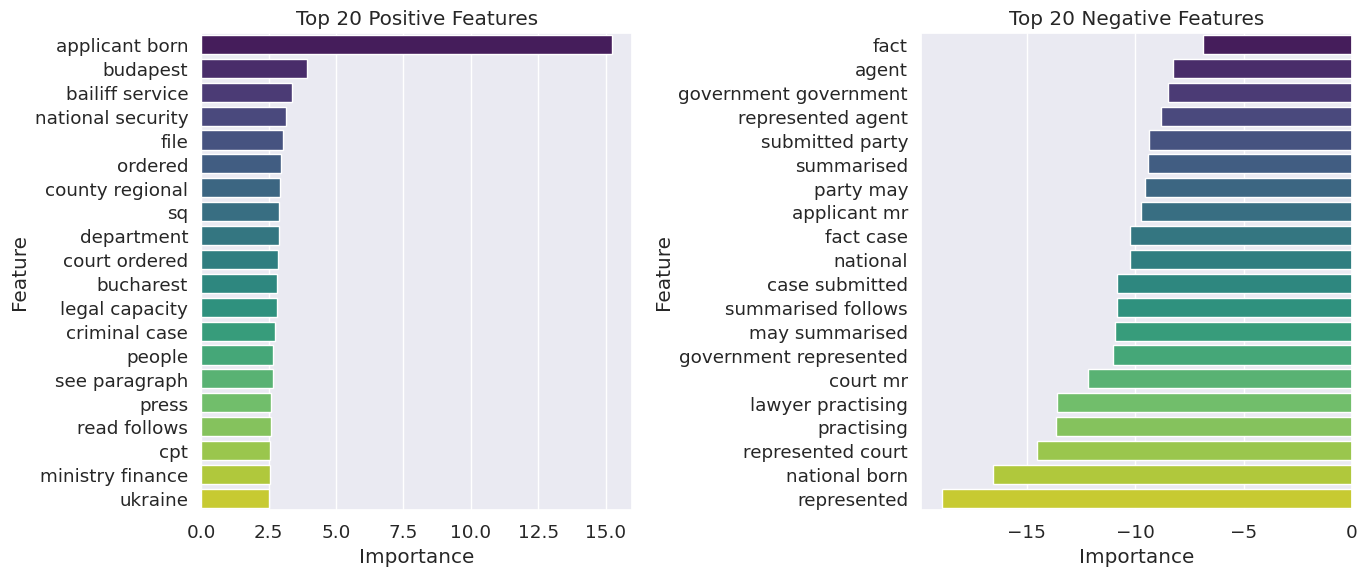

In [ ]:
feature_importance_df = {key: value for key, value in feature_importance_dict.items() if not re.search(r'\d', key)}
feature_importance_df = pd.DataFrame(list(feature_importance_df.items()), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 20 positive and top 20 negative features
top_pos = feature_importance_df.head(20)
top_neg = feature_importance_df.tail(20)

# Create subplots
sns.set(font_scale=1.2)
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

# Plot the top 20 positive features
sns.barplot(x='Importance', y='Feature', data=top_pos, ax=axs[0], palette='viridis')
axs[0].set_title('Top 20 Positive Features')

# Plot the top 20 negative features
sns.barplot(x='Importance', y='Feature', data=top_neg, ax=axs[1], palette='viridis')
axs[1].set_title('Top 20 Negative Features')

plt.tight_layout()
plt.show()

# Interpreting CNN on Bag-of-Words:

In [ ]:
unique_y = ["violation", "no-violation"]
explainer = lime_text.LimeTextExplainer(class_names=unique_y, verbose=True)

def predict_proba(arr):
  list_tokenized_ex = tok_tfidf.texts_to_sequences(arr)
  token_ex = pad_sequences(list_tokenized_ex, maxlen=max_len)
  pred = model_CNN_bow.predict(token_ex)

  l = []
  for i in pred:
    l.append(np.array([1-i[0], i[0]]))
  return np.array(l)

In [ ]:
explainer.explain_instance(df_train_x.iloc[6071], predict_proba).show_in_notebook(text=True)

157/157 [==============================] - 3s 17ms/step
Intercept 0.1107518307693
Prediction_local [-0.00105288]
Right: 8.234249726513099e-09
